In [2]:
import pandas as pd
from pathlib import Path

import json
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from matplotlib.ticker import MaxNLocator

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import pickle
import seaborn as sns
sns.set()


from utils import *



In [3]:
data = pd.read_parquet("../data_manipulation/final_night_data.parquet")

In [4]:
def set_season_tag(df, isnorth = True):
    if isnorth:
        df["season"] = (df['DateTime'].dt.month%12 + 3) // 3 # print(seasons)
    else:
        df["season"] = ((df['DateTime'].dt.month + 6)%12 + 3)//3
    return df, "season"

def extract_time_features(df):
    """
    Extract features from the timestamp for model training.
    
    Parameters:
    data (pd.DataFrame): DataFrame with 'Timestamp' and 'NEE' columns.
    
    Returns:
    pd.DataFrame: DataFrame with extracted features, list: features added to dataframe
    """
    df = df.copy()
    df['hour'] = df['DateTime'].dt.hour
    df['dayofweek'] = df['DateTime'].dt.dayofweek
    df['month'] = df['DateTime'].dt.month
    df['dayofyear'] = df['DateTime'].dt.dayofyear
    return df, ["hour", "dayofweek", "month", "dayofyear"]
    
def split_data(df, test_size=0.2):
    """
    Split data into training and test sets.
    
    Parameters:
    data (pd.DataFrame): DataFrame with 'Timestamp' and 'NEE' columns.
    test_size (float): Proportion of the data to include in the test split.
    
    Returns:
    tuple: Training and test DataFrames.
    """
    train_data, test_data = train_test_split(df, test_size=test_size, shuffle=False)
    return train_data.reset_index(drop=True), test_data.reset_index(drop=True)

def physics_nee(k, T, Tref=10, T0=46.02):
    e0 = k[:, 0]
    rb = k[:, 1]
    exp_term = np.exp(e0 * (1.0 / (Tref - T0) - 1.0 / (T - T0)))
    NEE = rb * exp_term
    return NEE

In [5]:
data, season_feat = set_season_tag(data)
data, time_feat = extract_time_features(data)

In [6]:
data = data[data["dNEE"].notna()].reset_index(drop=True)

In [7]:
data["NEE_phy"] = physics_nee(data[["E0", "rb"]].values, data.Ta.values)

### Noise Distribution and Calculating diffusion coefficient $\sigma_{night}$

In [8]:
phy_error = data.NEE - data.NEE_phy
noise_mu = np.mean(phy_error)
noise_std = np.std(phy_error)

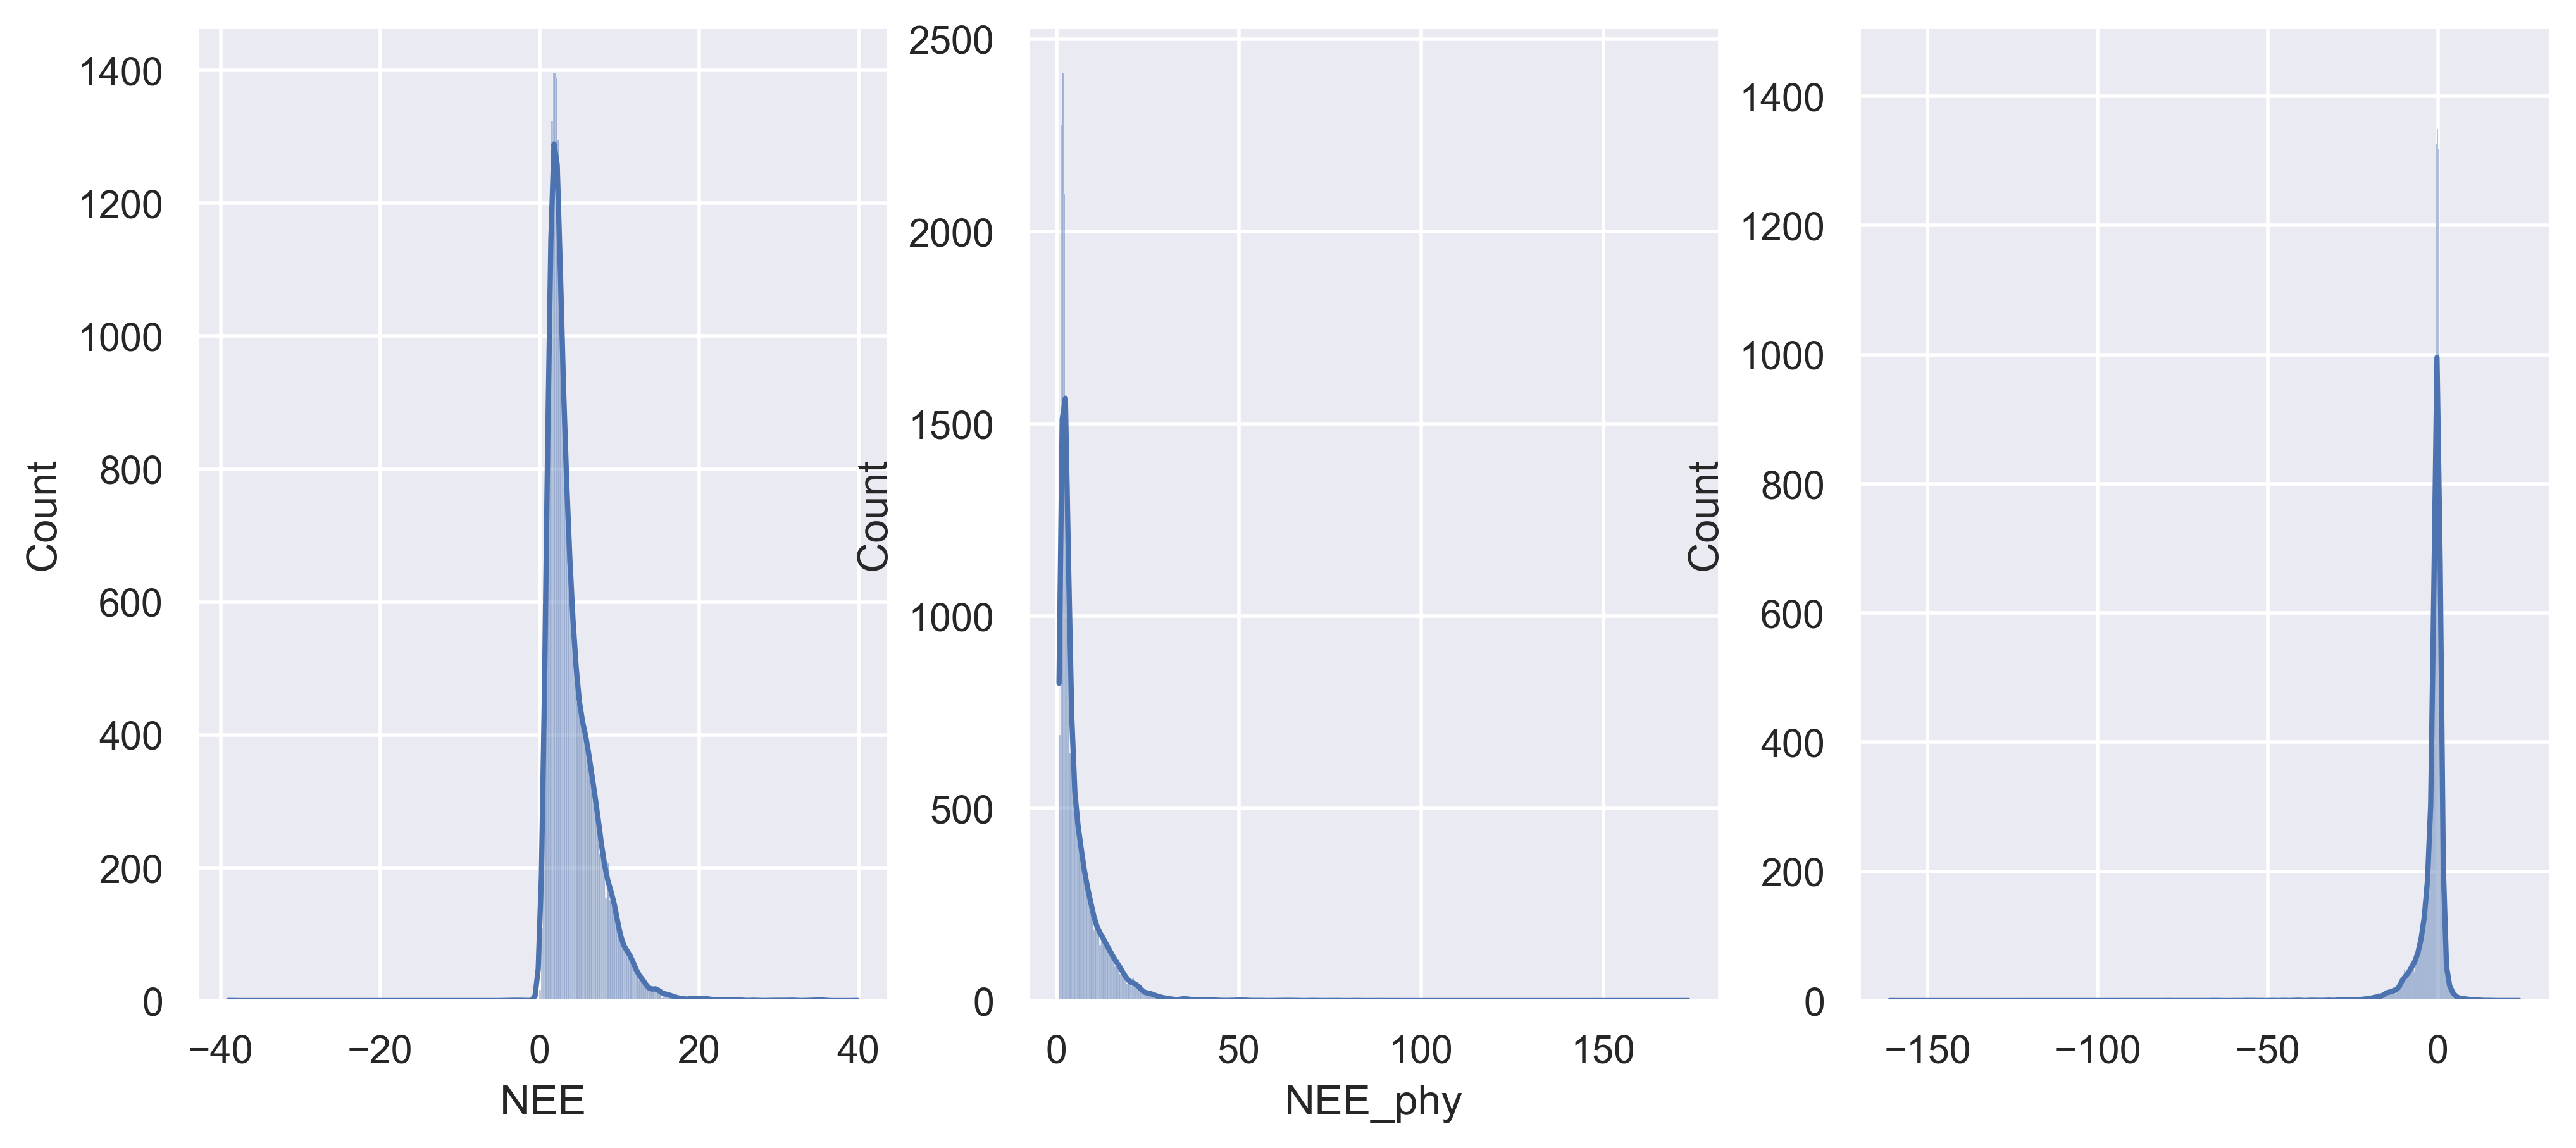

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 5), dpi=400)
sns.histplot(data.NEE, ax=ax[0], kde=True)
sns.histplot(data.NEE_phy, ax=ax[1], kde=True)    
sns.histplot(data.NEE - data.NEE_phy, ax=ax[2], kde=True)
plt.show()
